# Basic introduction to working with maps

# Introduction

This tutorial gives a basic introduction to working with gammapy maps, how to fill and visualise data. gammapy.maps contains classes to deal with representing pixelized data structures with at least two spatial dimensions representing coordinates on a sphere (e.g. an image in celestial coordinates). This can deal with images (2D), cubes (3D) and hyercubes.

More options to be added as the structure is developed

# Setup

Import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gammapy.data import DataStore
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap, MapCoord
import astropy.units as u
from gammapy.cube import fill_map_counts, MapMaker

# Data selection

We will use one Sgr A* run from the gammapy extra dataset.

In [7]:
source_pos = SkyCoord.from_name("Sgr A*")
ds=DataStore.from_dir("$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/")
obs=ds.obs(110380)
evts=obs.events

The available columns in the event file can be easily seen

In [9]:
evts.table

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,664502403.0454683,-92.63541,-30.514854,0.03902182,-0.9077294,-0.2727693,2
2,664502405.2579999,-92.64103,-28.262728,0.030796371,1.3443842,-0.2838398,2
3,664502408.8205513,-93.20372,-28.599625,0.04009629,1.0049409,-0.7769775,2
4,664502409.0143764,-94.03383,-29.269627,0.039580025,0.32684833,-1.496021,2
5,664502414.8090746,-93.330505,-30.319725,0.03035851,-0.716062,-0.8733348,2
6,664502415.5855484,-93.23232,-28.587324,0.034782063,1.0170497,-0.8021856,2
7,664502416.0332305,-92.62048,-29.781712,0.04999659,-0.17455244,-0.26183704,2
8,664502417.712146,-93.75603,-30.201115,0.041633684,-0.6013596,-1.242136,2


The most common use case is likely to be 3D maps, maps with 2 spatial and one energy dimension. However, there can be many other axes as well, eg: time, phase, telescope type, etc. 

Here, we will create one 3D map, and, just for example, one 4D map (with energy and MC_id as the non-spatial dimension)

The MapAxis class is used to to create the map axis.

In [10]:
binsz=0.05 
energy_axis = MapAxis.from_bounds(0.5,50.0,10,name='energy',unit='TeV',interp='log')
mc_axis=MapAxis.from_edges([0,500,1000,1750], interp="lin", name='MC_ID', unit=None)


A variable bin size can also be put on for different axis, in that case, binsize should be an array of the same dimension, eg:

In [11]:
binsz_var = np.sqrt((3.0*(energy_axis.center/100.)**-0.8)**2 + 0.1**2)

The WcsGeom class will create the required wcs geometry, a geom object

In [12]:
geom3d = WcsGeom.create(binsz=binsz, skydir=source_pos, width=15.0,
                       axes=[energy_axis])
geom4d = WcsGeom.create(binsz=binsz, skydir=source_pos, width=15.0,axes=[energy_axis, mc_axis])

The axes details can be accessed from within the geom object, and the map coordinates for each pixel using the get_coord()

In [15]:
[_.name for _ in geom4d.axes]

['energy', 'MC_ID']

In [18]:
map4d_coord=geom4d.get_coord()

In [34]:
lat_cord=map4d_coord.lat

Now, we fill the maps with the events

In [21]:
map3d=WcsNDMap.from_geom(geom=geom3d,unit='')
map4d=WcsNDMap.from_geom(geom=geom4d,unit='')

fill_map_counts(map3d,evts)
fill_map_counts(map4d,evts)


For a given source pos, the pixel position in the map can be obtained using 
coord_to_pix(). The geom.to_image() will give create a 2D geometry by dropping all non-spatial dimensions of this
geometry.

In [24]:
pix_lon,pix_lat=map3d.geom.to_image().coord_to_pix(source_pos)

Each spatial slice of the map can be plotted, where the idx represents the image slice to plot. eg: The slice (5,0) will plot the 5th energy and the 0th MC_id slice

(<matplotlib.figure.Figure at 0x181f809a58>,
 <matplotlib.colorbar.Colorbar at 0x181f987208>)

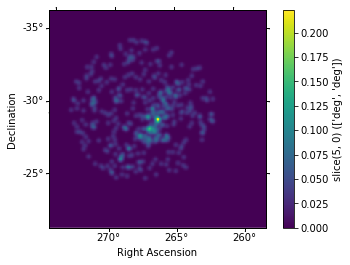

In [28]:
map4d.plot(idx=(5,0),smooth="gauss",radius=5,add_cbar=True)

The shape of the non-spatial axis can be seen using the shape parameter. The last 2 axes are the spatial ones.

In [33]:
geom4d.shape

(10, 3)

In [35]:
map4d.data.shape

(3, 10, 300, 300)

Multiple observations can be combined, and counts, background and exposure maps created using the MapMaker class

In [36]:
mmaker=MapMaker(geom3d,4.0*u.deg)
for obsid in ds.obs_table['OBS_ID']:
    mmaker.process_obs(ds.obs(obsid))

/Users/asinha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [38]:
mmaker.count_map.data.shape

(10, 300, 300)

Text(0.5,1,'Exposure')

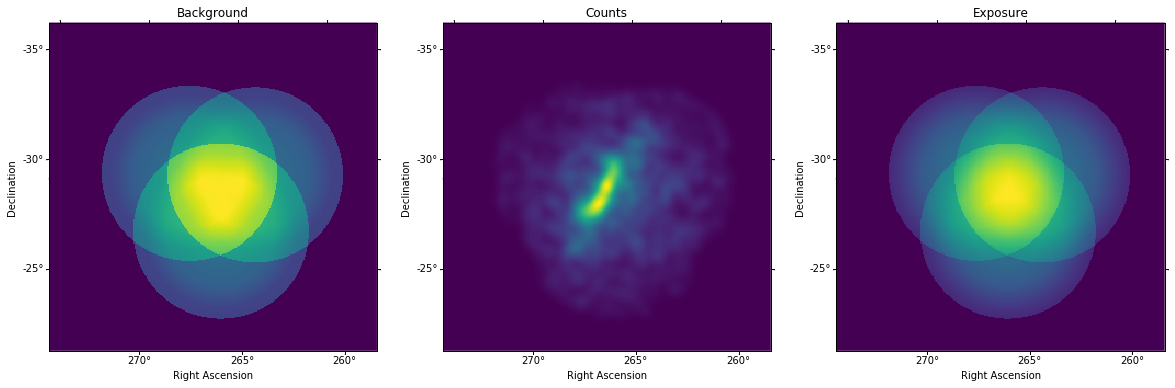

In [46]:
fig = plt.figure(figsize=(20,12))
ax1=fig.add_subplot(131,projection=geom3d.wcs)
mmaker.background_map.plot(ax=ax1,idx=2)
ax1.set_title("Background")

ax2=fig.add_subplot(132,projection=geom3d.wcs)
mmaker.count_map.plot(ax=ax2,idx=2,smooth="gauss",radius=0.5*u.deg)
ax2.set_title("Counts")

ax3=fig.add_subplot(133,projection=geom3d.wcs)
mmaker.exposure_map.plot(ax=ax3,idx=2)
ax3.set_title("Exposure")